# Summary

* Name: `dissipation-theory--Study-5.ipynb`
* Author: John A. Marohn
* Date: 2023-09-28
* Continued from: `dissipation-theory--Study-4.ipynb`
* Continued to: ---
* Look at ways to speed up the execution of the code in `dissipation-theory--Study-4.ipynb`.

# Preliminaries

In [1]:
import numpy as np
from dissipationtheory.constants import ureg, kb, epsilon0
from dissipationtheory.capacitance import CsphereOverSemi # <== now part of the codebase
from dissipationtheory.dissipation import CantileverModel, SampleModel2 # <== now part of the codebase
import matplotlib.pyplot as plt
from scipy import integrate
import numba
from numba import jit
import time

In [2]:
THIS = 'dissipation-theory--Study-5'

# Capacitance over a semiconductor substrate

How long does this computation take, and how many terms are needed for reasonable accuracy?  The default it $n = 20$ terms.

Compute the capacitance for a sphere of radius $r = 50 \: \mathrm{nm}$ over a semi-infinite sample with dielectric constant $\epsilon_{\mathrm{s}} = 11.9$ (silicon).  Compute the capacitance, and capacitance first and second derivatives, over a two-decade range of height $h$ starting at $r/100 = 0.5 \: \mathrm{nm}$ and ending at $20 \, r = 1000 \, \mathrm{nm}$.

In [3]:
r = ureg.Quantity(50., 'nm')

h = ureg.Quantity(
    np.logspace(
        np.log10(r.to('nm').magnitude/100),
        np.log10(20*r.to('nm').magnitude),
        num=100), 
    'nm')

eps = 11.9

In [4]:
h[0]

0.5 <Unit('nanometer')>

In [5]:
h[-1]

1000.0 <Unit('nanometer')>

Compute reference capacitances using $n = 50$ terms.

In [6]:
%%time
Cap_ref = {}
for index in [0, 1, 2]:
    Cap_ref[index] = CsphereOverSemi(index, height=h, radius=r, epsilon=eps, nterm=50)

CPU times: user 38.3 ms, sys: 3.98 ms, total: 42.3 ms
Wall time: 53.7 ms


Compute capacitances for various numbers of terms $n$.

In [7]:
%%time
Cap = {}
for index in [0, 1, 2]:
    Cap_vs_h = {}
    for key in ['10', '15', '20', '25', '30']:
        Cap_vs_h[key] = CsphereOverSemi(index, height=h, radius=r, epsilon=eps, nterm=int(key))
    Cap[index] = Cap_vs_h

CPU times: user 145 ms, sys: 5.66 ms, total: 150 ms
Wall time: 268 ms


These times are ([link](https://pythonspeed.com/articles/blocking-cpu-or-io/))

* `user`: the process CPU time
* `sys`: the operating system CPU time due to system calls from the process
* `Wall time`: the wall clock time (elapsed)

Observe that the time to compute three capacitances ($C$, $dC/dz$, and $d^2 C/d z^2$) at 100 height points is 100 to 300 ms.

Compute the relative error in the capacitances
\begin{equation}
\epsilon^{(k)}_{\mathrm{sphere}}(n) = \frac{C^{(k)}_{\mathrm{sphere}}(100) - C^{(k)}_{\mathrm{sphere}}(n)}{C^{(n)}_{\mathrm{sphere}}(100)}
\end{equation}
where $k = 0$ is the capacitance and $k = 1$ and $k - 2$ are the first and second derivates, respectively.

Plot the capacitances and relative errors.

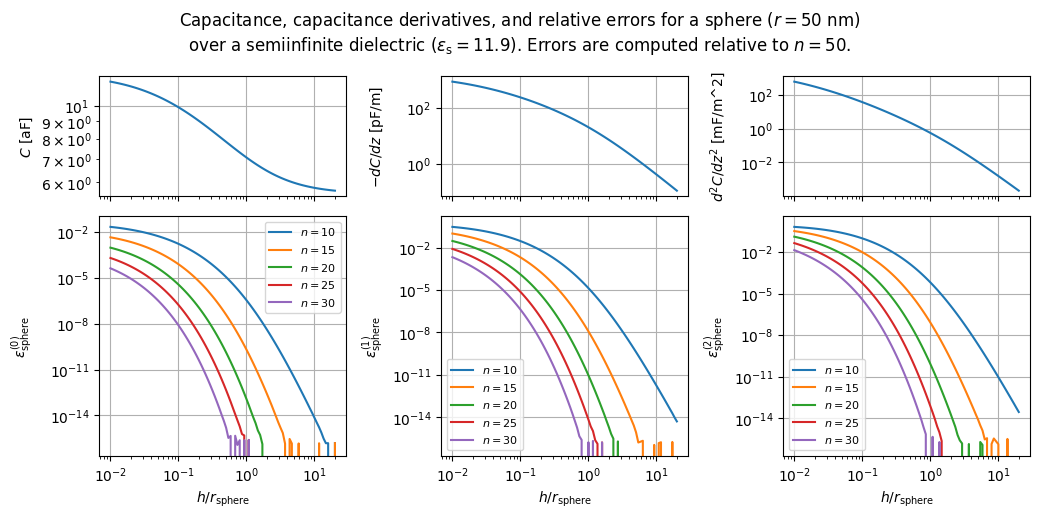

In [8]:
fig, axs = plt.subplots(2, len(Cap.keys()), figsize=(3*3.50, 3*1.75), sharex=True, gridspec_kw={'height_ratios': [1,2]})

for index, key, unit, Clabel, sign, in zip(
    np.arange(len(Cap.keys())),
    Cap.keys(), ['aF', 'pF/m', 'mF/m^2'], 
    ['$C$', '$-dC/dz$', '$d^2C/dz^2$'],
    [1, -1, 1]
):

    ylabel = Clabel + ' [' + unit + ']'
    x = (h/r).to('').magnitude
    y = sign*Cap_ref[index].to(unit).magnitude
    
    axs[0, index].set_ylabel(ylabel)
    axs[0, index].loglog(x, y)
    axs[0, index].grid(True)

    for height in Cap[index].keys():

        ylabel = r'$\epsilon^{(' + '{:}'.format(int(index)) + ')}_{\mathrm{sphere}}$'
        label = '$n = ' + '{:}'.format(int(height)) + '$'
        y = (Cap_ref[index].to(unit).magnitude - Cap[index][height].to(unit).magnitude)/Cap_ref[index].to(unit).magnitude

        axs[1, index].loglog(x, y, label=label)
        axs[1, index].set_ylabel(ylabel)
        axs[1, index].set_xlabel('$h/r_{\mathrm{sphere}}$')
        axs[1, index].grid(True)
        axs[1, index].legend(fontsize=8)

r_str = '{:0.0f}'.format(r.to('nm').magnitude)
eps_str = '{:0.1f}'.format(eps)

plt.suptitle('Capacitance, capacitance derivatives, and relative errors' +
             ' for a sphere ($r = $' + r_str + ' nm)' +
             '\nover a semiinfinite dielectric ($\epsilon_{\mathrm{s}} = $' + eps_str + ').' +
             ' Errors are computed relative to $n = 50$.')        

fig.align_ylabels()
plt.tight_layout()

plt.savefig(THIS + '--Fig-1', dpi=300)
plt.savefig(THIS + '--Fig-1.pdf')

plt.show()

**Summary**.  
* Relative error is worse at small $h$ and worst for the second derivative.
* Using $n = 20$ gives a relative error for the second derivative of 1% at $h \geq 0.1 \: r_{\mathrm{sphere}}$.

So use $n = 20$ terms.

In [9]:
%%time
for index in [0, 1, 2]:
    CsphereOverSemi(index, height=h, radius=r, epsilon=eps, nterm=20)

CPU times: user 16 ms, sys: 2.13 ms, total: 18.2 ms
Wall time: 25.9 ms


With $n = 20$ terms, it takes about 35 ms to compute the three derivatives over 100 height points.

# Reproduce the parallel dissipation calculation

Reproduce below the parallel dissipation calculation for `Sample2` from `Study-4`.

In [10]:
def theta2norm(omega, sample, power):

    r1 = sample.Ld**2 / (sample.epsilon_s * sample.LD**2)
    r2 = sample.z_r**2 / (sample.epsilon_s * sample.LD**2)
    r3 = sample.z_r**2 / sample.Ld**2
    lambduh = (complex(0,1) * r1 * omega / np.sqrt(omega**2 + r2 + complex(0,1) * r3)).to('dimensionless').magnitude
     
    khd = (omega * sample.h_d / sample.z_r).to('dimensionless').magnitude

    r1 = 1/sample.epsilon_d
    t1 = sample.epsilon_eff * np.tanh(khd) + (1 - lambduh) * sample.epsilon_d
    t2 = sample.epsilon_eff + (1 - lambduh) * sample.epsilon_d * np.tanh(khd)

    theta = ((r1 * t1) / t2).magnitude

    ratio = (1 - theta) / (1 + theta)
    exponent = (2 * sample.cantilever.d / sample.z_r).to('dimensionless').magnitude

    integrand = omega**power * np.exp(-1 * omega * exponent) * np.imag(ratio) 

    return integrand

In [11]:
def C(power, theta, sample):
    
    prefactor = (-1**(power + 1) * kb * ureg.Quantity(300., 'K')) / \
          (4 * np.pi * epsilon0 * sample.cantilever.omega_c * sample.z_r**(power+1))
    
    integral = integrate.quad(theta, 0., np.inf, args=(sample, power))[0]
    
    return (prefactor * 0.50 * integral).to_base_units()

In [12]:
def gamma_parallel(theta, sample):

    prefactor = (sample.cantilever.V_ts**2 / (kb * ureg.Quantity(300., 'K'))).to('V/C')
    
    c0 = CsphereOverSemi(index=0, 
            height=sample.cantilever.d * np.ones(1), 
            radius=sample.cantilever.R, 
            epsilon=sample.epsilon_d.real.magnitude)

    return prefactor * c0 * c0 * C(2, theta, sample)

Define the sample.

In [13]:
sample2 = SampleModel2(

    cantilever = CantileverModel(
        f_c = ureg.Quantity(81, 'kHz'), 
        V_ts = ureg.Quantity(3, 'V'), 
        R = ureg.Quantity(80, 'nm'), 
        d = ureg.Quantity(300, 'nm')),
    h_d = ureg.Quantity(0., 'nm'),
    epsilon_d = ureg.Quantity(complex(11.9, -0.05), ''),
    epsilon_s = ureg.Quantity(complex(11.9, -0.05), ''),
    mu = ureg.Quantity(2.7e-10, 'm^2/(V s)'),
    rho = ureg.Quantity(1e21, '1/m^3'),
    z_r = ureg.Quantity(300, 'nm')
)

Loop over charge density and compute the parallel friction.

In [14]:
%%time
rho2_ = ureg.Quantity(np.logspace(start=15, stop=29, num=30), '1/m^3')
gamma2 = ureg.Quantity(np.zeros_like(rho2_), 'pN s/m')

for index, rho__ in enumerate(rho2_):

    sample2.rho = rho__
    gamma2[index] = gamma_parallel(theta2norm, sample2)

CPU times: user 15 s, sys: 213 ms, total: 15.2 s
Wall time: 16.6 s


Painfully slow!

Plot the results.

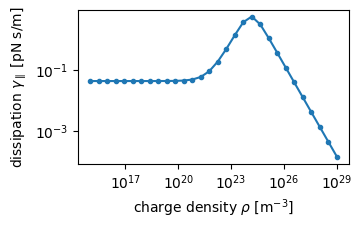

In [15]:
plt.figure(figsize=(3.50, 2.00))
plt.loglog(rho2_.to('1/m^3').magnitude, gamma2.to('pN s/m').magnitude, '.-')
plt.xlabel(r'charge density $\rho$ [m$^{-3}$]')  # need a raw string here because \r is the special carriage return character
plt.ylabel('dissipation $\gamma_{\parallel}$ [pN s/m]')
plt.show()

# Try to speed up the numerical integration

Read about `numba` and `jit`

* "A ~5 minute guide to Numba", https://numba.readthedocs.io/en/stable/user/5minguide.html
* "First Steps with numba" https://numba.pydata.org/numba-doc/0.12.2/tutorial_firststeps.html 
* "How to use Numba to perform multiple integration in SciPy with an arbitrary number of variables and parameters?", https://stackoverflow.com/questions/51109429/how-to-use-numba-to-perform-multiple-integration-in-scipy-with-an-arbitrary-numb

## Test drive `numba`

Try `numba` on a bubble sort algorithm, adapting code from the "First Steps with numba" page.

In [16]:
def bubblesort(X):
    N = len(X)
    for end in range(N, 1, -1):
        for i in range(end - 1):
            cur = X[i]
            if cur > X[i + 1]:
                tmp = X[i]
                X[i] = X[i + 1]
                X[i + 1] = tmp

Create an array of sorted values and randomly shuffle them.

In [17]:
original = np.arange(0.0, 10.0, 0.01, dtype='f4')
shuffled = original.copy()
np.random.shuffle(shuffled)

Create a copy, bubble sort the copy, and compare to the original.

In [18]:
sorted1 = shuffled.copy()
%timeit bubblesort(sorted1)
print(np.array_equal(sorted1, original))

177 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
True


Use `numba` to make a compiled version of the bubble sort function.

In [19]:
@numba.jit("void(f4[:])", nopython=True)
def bubblesort_jit(X):
    N = len(X)
    for end in range(N, 1, -1):
        for i in range(end - 1):
            cur = X[i]
            if cur > X[i + 1]:
                tmp = X[i]
                X[i] = X[i + 1]
                X[i + 1] = tmp

In [20]:
sorted2 = shuffled.copy()
%timeit bubblesort_jit(sorted2)
print(np.array_equal(sorted2, original))

282 µs ± 13.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
True


The speed has been improved by a factor of

In [21]:
print('{:0.0f}'.format(150E-3/218E-6))

688


Impressive!  The execution has been sped up almost 1000-fold.

## Research passing classes to functions in `numba`

I want a `numba` implimentation of the following function.

In [22]:
def theta2norm(omega, sample, power):

    r1 = sample.Ld**2 / (sample.epsilon_s * sample.LD**2)
    r2 = sample.z_r**2 / (sample.epsilon_s * sample.LD**2)
    r3 = sample.z_r**2 / sample.Ld**2
    lambduh = (complex(0,1) * r1 * omega / np.sqrt(omega**2 + r2 + complex(0,1) * r3)).to('dimensionless').magnitude
     
    khd = (omega * sample.h_d / sample.z_r).to('dimensionless').magnitude

    r1 = 1/sample.epsilon_d
    t1 = sample.epsilon_eff * np.tanh(khd) + (1 - lambduh) * sample.epsilon_d
    t2 = sample.epsilon_eff + (1 - lambduh) * sample.epsilon_d * np.tanh(khd)

    theta = ((r1 * t1) / t2).magnitude

    ratio = (1 - theta) / (1 + theta)
    exponent = (2 * sample.cantilever.d / sample.z_r).to('dimensionless').magnitude

    integrand = omega**power * np.exp(-1 * omega * exponent) * np.imag(ratio) 

    return integrand

In [23]:
%timeit theta2norm(1, sample2, 2)

7.41 ms ± 1.25 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


Try adding `@numba.jit(nopython=True)` before the function and get many errors when I try to run it.  The message is

    This error may have been caused by the following argument(s):
    - argument 1: Cannot determine Numba type of <class 'dissipationtheory.dissipation.SampleModel2'>

So `numba` cannot handle my data struture.  Research using `numba` with classes:

* "Compiling Python classes with @jitclass", https://numba.pydata.org/numba-doc/dev/user/jitclass.html
* "How to use numba.jit with methods", https://numba.pydata.org/numba-doc/dev/user/jitclass.html
* "How to nest numba jitclass", https://stackoverflow.com/questions/38682260/how-to-nest-numba-jitclass
* "How to use formatted strings in numba.jit function?", https://stackoverflow.com/questions/62026848/how-to-use-formatted-strings-in-numba-jit-function
* "Passing a class object as a function argument, in Numba optimized Python", https://stackoverflow.com/questions/49098254/passing-a-class-object-as-a-function-argument-in-numba-optimized-python

Reading the above discussions, it looks like I am going to have to rewrite my class definitions so they are compatible with `numba`.  Start with my `CantileverModel` object and strip it down until I can get something to work.

In [40]:
from numba import float64
from numba.experimental import jitclass

CantileverModelSpec = [
    ('f_c',float64),
    ('V_ts',float64),
    ('R',float64),
    ('d',float64)]  # <== can't use pint, so no units :-(

@jitclass(CantileverModelSpec)
class CantileverModelJit(object):

    def __init__(self, f_c, V_ts, R, d):

        self.f_c = f_c
        self.V_ts = V_ts
        self.R = R
        self.d = d

    @property
    def omega_c(self):
        return 2 * np.pi * self.f_c

    def print(self):  # <=== can't use the __repr__ function :-(

        print("   cantilever freq = ", self.f_c, "Hz") # <== can't use formatting strings here, keep it simple  :-(
        print("                   = ", self.omega_c, "rad/s")
        print("tip-sample voltage = ", self.V_ts, "V")
        print("            radius = ", self.R, "m")
        print("            height = ", self.d, "m")

The object is created and we can call the object's `.print` function.

In [41]:
cantilever_jit =  CantileverModelJit(81.01e3, 3.01,  80.01, 300.01)
print(cantilever_jit.omega_c)
cantilever_jit.print()

509000.8417346183
   cantilever freq =  81010.0 Hz
                   =  509000.8417346183 rad/s
tip-sample voltage =  3.01 V
            radius =  80.01 m
            height =  300.01 m


Confirm that `@property` is still doing its job.  Observe that if I update the `.f_c` attribute, then the `.omega_c` atrribute gets updated as expected:

In [42]:
cantilever_jit.f_c = 162.02e3
cantilever_jit.print()

   cantilever freq =  162020.0 Hz
                   =  1018001.6834692366 rad/s
tip-sample voltage =  3.01 V
            radius =  80.01 m
            height =  300.01 m


OK, so far so good.  

Following the example [here](https://stackoverflow.com/questions/38682260/how-to-nest-numba-jitclass), create a second object that incorporates the first object.

In [43]:
from numba import deferred_type
from numba import complex128

CantileverModelJit_type = deferred_type()
CantileverModelJit_type.define(CantileverModelJit.class_type.instance_type)

SampleModel1Spec = [('cantilever', CantileverModelJit_type),('epsilon_s',complex128)]

@jitclass(SampleModel1Spec)
class SampleModel1Jit(object):
    
    def __init__(self, cantilever, epsilon_s):

        self.cantilever = cantilever
        self.epsilon_s = epsilon_s

    def print(self):

        self.cantilever.print()
        print(" epsilon (real) = ", self.epsilon_s.real)
        print(" epsilon (imag) = ", self.epsilon_s.imag)

The object is created *and* we can use the sub-object's `.print` function.

In [44]:
sample1_jit = SampleModel1Jit(CantileverModelJit(71.01e3, 3.01,  80.01, 300.01), complex(11.9,-0.05))
print(sample1_jit.cantilever.omega_c)
sample1_jit.cantilever.print()

446168.9886628224
   cantilever freq =  71010.0 Hz
                   =  446168.9886628224 rad/s
tip-sample voltage =  3.01 V
            radius =  80.01 m
            height =  300.01 m


The new object's print function works as expected.

In [45]:
sample1_jit.print()

   cantilever freq =  71010.0 Hz
                   =  446168.9886628224 rad/s
tip-sample voltage =  3.01 V
            radius =  80.01 m
            height =  300.01 m
 epsilon (real) =  11.9
 epsilon (imag) =  -0.05


Confirm that `@property` is still doing its job:

In [46]:
sample1_jit.cantilever.f_c = 162.02e3
print(sample1_jit.cantilever.omega_c)

1018001.6834692366


OK, at this point I have have created nested classes, implimented in `numba`.

Following advice [here](https://stackoverflow.com/questions/49098254/passing-a-class-object-as-a-function-argument-in-numba-optimized-python), write a function that takes as an input the above object and computes something using the numbers stored in the object.

In [63]:
@jit(float64(float64,SampleModel1Jit.class_type.instance_type), nopython=True)
def function_jit(omega, sample):

    return(omega * sample.epsilon_s.imag * sample.cantilever.omega_c)

In [64]:
function_jit(1.0, sample1_jit)

-50900.08417346183

OK!  I have been able to define `numba` compatible classes and written a compiled function that accepts these classes as input.  I have to write the classes a little differently.  If I want a `numba` compatible class,

* I can use `@property`
* I can only use the defined types as inputs; no `pint` objects with units, just floats
* I can't use `__repr__`
* I can't use fancy formatted print statements

Losing units is frustrating.  Plan on using SI units for everything, and convert to a object with units at the very end.

I think I have all the pieces in place.   Now code things up fully, starting with `SampleModel2` and `theta2norm` because that combination contains more well-behaved parameters and functions.

In [65]:
from dissipationtheory.constants import ureg, epsilon0, qe, kb

CantileverModelJit_type = deferred_type()
CantileverModelJit_type.define(CantileverModelJit.class_type.instance_type)

SampleModel2Spec = [
    ('cantilever', CantileverModelJit_type),
    ('epsilon_d',complex128),
    ('h_d', float64),
    ('epsilon_s',complex128),
    ('mu',float64),
    ('rho',float64),
    ('z_r',float64)]

kb_= kb.to('J/K').magnitude
T_ = 300.
qe_ = qe.to('C').magnitude
epsilon0_ = epsilon0.to('C/(V m)').magnitude

@jitclass(SampleModel2Spec)
class SampleModel2Jit(object):
    
    def __init__(self, cantilever, epsilon_d, h_d, epsilon_s, mu, rho, z_r):

        self.cantilever = cantilever
        self.epsilon_d = epsilon_d
        self.h_d = h_d
        self.epsilon_s = epsilon_s
        self.mu = mu
        self.rho = rho
        self.z_r = z_r

    @property
    def D(self):
        return (kb_ * T_ * self.mu) / qe_

    @property
    def Ld(self):
        return np.sqrt(self.D / self.cantilever.omega_c)
    
    @property
    def LD(self):
        return np.sqrt((epsilon0_ * kb_ * T_)/(self.rho * qe_ * qe_))

    @property
    def epsilon_eff(self):
        return self.epsilon_s - complex(0,1) * self.Ld**2 / self.LD**2

    def print(self):

        print("cantilever")
        print("-=========")
        self.cantilever.print()
        print("")
        print("dielectric")
        print("==========")
        print(" epsilon (real) = ", self.epsilon_d.real)
        print(" epsilon (imag) = ", self.epsilon_d.imag)
        print("      thickness = ", self.h_d, "nm")
        print("")
        print("semiconductor")
        print("=============")
        print("          epsilon (real) = ", self.epsilon_s.real)
        print("          epsilon (imag) = ", self.epsilon_s.imag)
        print("               thickness = infinite")
        print("                mobility = ", self.mu, "m^2/(V s)")
        print("      diffusion constant = ", self.D, "m^2/s")
        print("          charge density = ", self.rho, "m^{{-3}}")
        print("        reference height = ", self.z_r, "m")
        print("            Debye length = ", self.LD, "m")
        print("        diffusion length = ", self.Ld, "m")
        print("effective epsilon (real) = ", self.epsilon_eff.real)
        print("effective epsilon (imag) = ", self.epsilon_eff.imag)

In [66]:
sample2_jit = SampleModel2Jit(
    cantilever=CantileverModelJit(81.0e3, 3.,  80E-9, 300E-9),
    epsilon_d=complex(11.9,-0.05),
    h_d=0.,
    epsilon_s=complex(11.9,-0.05),
    mu=2.7E-10,
    rho=1e21,
    z_r=300)

# and for comparison

sample2 = SampleModel2(
    cantilever = CantileverModel(
        f_c = ureg.Quantity(81, 'kHz'), 
        V_ts = ureg.Quantity(3, 'V'), 
        R = ureg.Quantity(80, 'nm'), 
        d = ureg.Quantity(300, 'nm')),
    h_d = ureg.Quantity(0., 'nm'),
    epsilon_d = ureg.Quantity(complex(11.9, -0.05), ''),
    epsilon_s = ureg.Quantity(complex(11.9, -0.05), ''),
    mu = ureg.Quantity(2.7e-10, 'm^2/(V s)'),
    rho = ureg.Quantity(1e21, '1/m^3'),
    z_r = ureg.Quantity(300, 'nm')
)

In [67]:
sample2_jit.print()

cantilever
-=========
   cantilever freq =  81000.0 Hz
                   =  508938.0098815465 rad/s
tip-sample voltage =  3.0 V
            radius =  8e-08 m
            height =  3e-07 m

dielectric
 epsilon (real) =  11.9
 epsilon (imag) =  -0.05
      thickness =  0.0 nm

semiconductor
          epsilon (real) =  11.9
          epsilon (imag) =  -0.05
               thickness = infinite
                mobility =  2.7e-10 m^2/(V s)
      diffusion constant =  6.980039959763987e-12 m^2/s
          charge density =  1e+21 m^{{-3}}
        reference height =  300.0 m
            Debye length =  3.7797775481848936e-08 m
        diffusion length =  3.7033649406515185e-09 m
effective epsilon (real) =  11.9
effective epsilon (imag) =  -0.059599763628316975


In [68]:
sample2

cantilever

      resonance freq = 81.000 kHz
                     = 5.089e+05 rad/s
  tip-sample voltage = 3.000 V
              radius = 80.000 nm
              height = 300.000 nm

dielectric

  epsilon (real) = 11.900
  epsilon (imag) = -0.050
       thickness = 0.0 nm

semiconductor

             epsilon (real) = 11.900
             epsilon (imag) = -0.050
                  thickness = infinite
                   mobility = 2.70e-10 m^2/(V s)
         diffusion constant = 6.98e-12 m^2/s
             charge density = 1.00e+21 m^{-3}
           reference height = 300.0 nm
               Debye length = 37.8 nm
           diffusion length = 3.7 nm
   effective epsilon (real) = 11.900
   effective epsilon (imag) = -0.060


By inpsection the new `numba`-compatible object gives the same diffusion constant, Debye length, diffusion length, and effective dielectric constant as the Python object.  Nice!

Next, the function for computing the integrand.

In [145]:
@jit(float64(float64,SampleModel2Jit.class_type.instance_type,float64), nopython=True)
def theta2norm_jit(omega, sample, power):

    r1 = sample.Ld**2 / (sample.epsilon_s * sample.LD**2)
    r2 = sample.z_r**2 / (sample.epsilon_s * sample.LD**2)
    r3 = sample.z_r**2 / sample.Ld**2
    lambduh = complex(0,1) * r1 * omega / np.sqrt(omega**2 + r2 + complex(0,1) * r3)
     
    khd = omega * sample.h_d / sample.z_r

    r1 = 1/sample.epsilon_d
    t1 = sample.epsilon_eff * np.tanh(khd) + (1 - lambduh) * sample.epsilon_d
    t2 = sample.epsilon_eff + (1 - lambduh) * sample.epsilon_d * np.tanh(khd)

    theta = (r1 * t1) / t2

    ratio = (1 - theta) / (1 + theta)
    exponent = 2 * sample.cantilever.d / sample.z_r

    integrand = omega**power * np.exp(-1 * omega * exponent) * np.imag(ratio) 
    
    return integrand

In [146]:
%timeit theta2norm_jit(1, sample2_jit, 2)

1.39 µs ± 162 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


Compared to 7.41 ms for the pure Python function `theta2norm`.  The speed up is a factor of

In [147]:
7.31E-3/1.07E-6

6831.77570093458

Which is looking pretty impressive! 

Read "Numba jit with scipy", https://stackoverflow.com/questions/55317665/numba-jit-with-scipy.  Read that "SciPy is already a high-performance library so in most cases I would expect numba to perform worse (or rarely: slightly better)".  Try implimenting the 

In [148]:
%timeit theta2norm_jit(1, sample2_jit, 2)

1.41 µs ± 326 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [149]:
%time C(2, theta2norm, sample2).to('V^2 s/m^2')

CPU times: user 272 ms, sys: 5.45 ms, total: 278 ms
Wall time: 287 ms


0.0007132173907135605 <Unit('second * volt ** 2 / meter ** 2')>

We only have to slightly modify the function `C`.  In the `jit`-compatible sample object, the cantilever frequency `.omega_c` and reference height `.z_r` do not have units.  So we have to add the units back in for the prefactor to come out right.  To help convergence, I'm changing the upper integration limit from `np.inf` to a large number, `1e10`.  Leaving the upper limit at `np.inf`, the integral is junk more than half the time.

In [190]:
def C_jit(power, theta, sample):
    
    prefactor = (-1**(power + 1) * kb * ureg.Quantity(300., 'K')) / \
          (4 * np.pi * epsilon0 * ureg.Quantity(sample.cantilever.omega_c,'1/s') * ureg.Quantity(sample.z_r,'m')**(power+1))
    
    integral = integrate.quad(theta, 0., 1e10, args=(sample, power))[0]  # <== give this a finite upper limit
    
    return (prefactor * 0.50 * integral).to_base_units()

In [191]:
%time C_jit(2, theta2norm_jit, sample2_jit).to('V^2 s/m^2')

CPU times: user 1.15 ms, sys: 3 µs, total: 1.15 ms
Wall time: 1.16 ms


0.0007132172246921261 <Unit('second * volt ** 2 / meter ** 2')>

The integral comes out the same but, surprisingly, we now get an integration warning!

We only need a slight tweak in the code below.  Again, add the units back in to the cantilever parameters for the prefactor to come out right.

In [192]:
def gamma_parallel_jit(theta, sample):

    prefactor = (ureg.Quantity(sample.cantilever.V_ts,'V')**2 / (kb * ureg.Quantity(300., 'K'))).to('V/C')
    
    c0 = CsphereOverSemi(index=0, 
            height=ureg.Quantity(sample.cantilever.d,'m') * np.ones(1), 
            radius=ureg.Quantity(sample.cantilever.R,'m'), 
            epsilon=sample.epsilon_d.real)

    return prefactor * c0 * c0 * C_jit(2, theta, sample)

In [193]:
%time gamma_parallel_jit(theta2norm_jit, sample2_jit).to('pN s/m')

CPU times: user 5.27 ms, sys: 869 µs, total: 6.13 ms
Wall time: 9.91 ms


Magnitude,[0.00014796221158006243]
Units,piconewton second/meter


Now reproduce the main computation.

In [194]:
%%time
gamma2_jit = ureg.Quantity(np.zeros_like(rho2_), 'pN s/m')

for index, rho__ in enumerate(rho2_):

    sample2_jit.rho = rho__.to('1/m^3').magnitude
    gamma2_jit[index] = gamma_parallel_jit(theta2norm_jit, sample2_jit)

CPU times: user 158 ms, sys: 10.9 ms, total: 169 ms
Wall time: 216 ms


Compare to a wall time of 16.6 s for the Python implemenation.  We have sped up the computation by a factor of about 50.

However, a lot of the integrations are junk!

In [195]:
for index, rho__ in enumerate(rho2_):
    print('{:0.2e} {:+4.2e} {:+4.2e}'.format(
        rho__.magnitude, 
        gamma2[index].magnitude,
        gamma2_jit[index].magnitude))
    

1.00e+15 +4.22e-02 +4.22e-02
3.04e+15 +4.22e-02 +4.22e-02
9.24e+15 +4.22e-02 +4.22e-02
2.81e+16 +4.22e-02 +4.22e-02
8.53e+16 +4.22e-02 +4.22e-02
2.59e+17 +4.22e-02 +4.22e-02
7.88e+17 +4.22e-02 +4.22e-02
2.40e+18 +4.22e-02 +4.22e-02
7.28e+18 +4.23e-02 +4.23e-02
2.21e+19 +4.24e-02 +4.24e-02
6.72e+19 +4.28e-02 +4.28e-02
2.04e+20 +4.38e-02 +4.38e-02
6.21e+20 +4.72e-02 +4.72e-02
1.89e+21 +5.73e-02 +5.73e-02
5.74e+21 +8.81e-02 +8.81e-02
1.74e+22 +1.82e-01 +1.82e-01
5.30e+22 +4.65e-01 +4.65e-01
1.61e+23 +1.31e+00 +1.31e+00
4.89e+23 +3.47e+00 +3.47e+00
1.49e+24 +5.30e+00 +5.30e+00
4.52e+24 +2.93e+00 +2.93e+00
1.37e+25 +1.05e+00 +1.05e+00
4.18e+25 +3.48e-01 +3.48e-01
1.27e+26 +1.15e-01 +1.15e-01
3.86e+26 +3.79e-02 +3.79e-02
1.17e+27 +1.25e-02 +1.25e-02
3.56e+27 +4.11e-03 +4.11e-03
1.08e+28 +1.36e-03 +1.36e-03
3.29e+28 +4.48e-04 +4.48e-04
1.00e+29 +1.48e-04 +1.48e-04


Plot the results.  When the integral is positive, it seems to be generally correct.

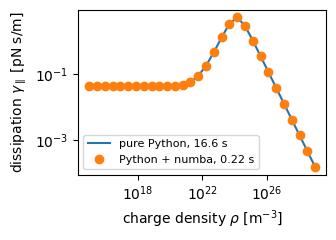

In [220]:
plt.figure(figsize=(3.50, 2.50))
plt.loglog(rho2_.to('1/m^3').magnitude, gamma2.to('pN s/m').magnitude, '-', label='pure Python, 16.6 s')
plt.loglog(rho2_.to('1/m^3').magnitude, gamma2_jit.to('pN s/m').magnitude, 'o', label='Python + numba, 0.22 s')
plt.xlabel(r'charge density $\rho$ [m$^{-3}$]')  # need a raw string here because \r is the special carriage return character
plt.ylabel('dissipation $\gamma_{\parallel}$ [pN s/m]')
plt.legend(fontsize=8)
plt.tight_layout()

plt.savefig(THIS + '--Fig-2', dpi=300)
plt.savefig(THIS + '--Fig-2.pdf')

plt.show()

Plot relative difference.

In [221]:
err = ((gamma2 - gamma2_jit)/gamma2).magnitude

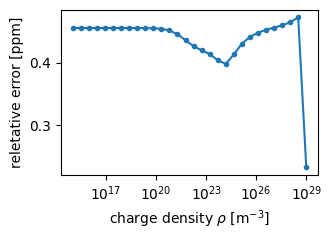

In [222]:
plt.figure(figsize=(3.50, 2.50))
plt.semilogx(rho2_.to('1/m^3').magnitude, err * 1e6, '.-')
plt.xlabel(r'charge density $\rho$ [m$^{-3}$]')  # need a raw string here because \r is the special carriage return character
plt.ylabel('reletative error [ppm]')
plt.tight_layout()

plt.savefig(THIS + '--Fig-3', dpi=300)
plt.savefig(THIS + '--Fig-3.pdf')

plt.show()

In summary, using the `numba` package I have sped up the calculation of the parallel dissipation over a semiconductor approximately 75 fold.